In [3]:
from zoish.feature_selectors.zoish_feature_selector import ScallyShapFeatureSelector
import xgboost
from optuna.pruners import HyperbandPruner
from optuna.samplers._tpe.sampler import TPESampler
from sklearn.model_selection import KFold,train_test_split
import pandas as pd
from sklearn.pipeline import Pipeline
from feature_engine.imputation import (
    CategoricalImputer,
    MeanMedianImputer
    )
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score)

# Example 1 : Use Adult Data Set (a classification problem)
  
https://archive.ics.uci.edu/ml/datasets/Adult

In [4]:
urldata= "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
# column names
col_names=["age", "workclass", "fnlwgt" , "education" ,"education-num",
"marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week",
"native-country","label"
]
# read data
data = pd.read_csv(urldata,header=None,names=col_names,sep=',')
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Define labels


In [5]:
data.loc[data['label']=='<=50K','label']=0
data.loc[data['label']==' <=50K','label']=0

data.loc[data['label']=='>50K','label']=1
data.loc[data['label']==' >50K','label']=1

data['label']=data['label'].astype(int)

# Train test split

In [6]:
X = data.loc[:, data.columns != "label"]
y = data.loc[:, data.columns == "label"]


X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.33, stratify=y['label'], random_state=42)


# Find feature types for later use

In [7]:
int_cols =  X_train.select_dtypes(include=['int']).columns.tolist()
float_cols =  X_train.select_dtypes(include=['float']).columns.tolist()
cat_cols =  X_train.select_dtypes(include=['object']).columns.tolist()


# Define Feature selector and set it argumens 

In [8]:

SFC_XGBCLS_OPTUNA = ScallyShapFeatureSelector(
        n_features=5,
        estimator=xgboost.XGBClassifier(),
        estimator_params={
            "max_depth": [2, 3],
            "min_child_weight": [0.1, 0.9],
            "gamma": [1, 9],
        },
        hyper_parameter_optimization_method="grid",
        shap_version="v0",
        measure_of_accuracy="f1",
        list_of_obligatory_features=[],
        test_size=0.33,
        cv=KFold(n_splits=3, random_state=42, shuffle=True),
        with_shap_summary_plot=True,
        with_stratified=False,
        verbose=0,
        random_state=42,
        n_jobs=-1,
        n_iter=100,
        eval_metric="auc",
        number_of_trials=20,
        sampler=TPESampler(),
        pruner=HyperbandPruner(),
    )


Setting value for n_features
Setting value for estimator
Getting value for estimator
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)
Getting value for estimator
Getting value for estimator
Getting value for estimator
Getting value for estimator
Getting value for estimator
Getting value for estimator
Gettin

# Build sklearn Pipeline

In [9]:


pipeline =Pipeline([
            # int missing values imputers
            ('intimputer', MeanMedianImputer(
                imputation_method='median', variables=int_cols)),
            # category missing values imputers
            ('catimputer', CategoricalImputer(variables=cat_cols)),
            #
            ('catencoder', OrdinalEncoder()),
            # feature selection
            ('SFC_XGBCLS_OPTUNA', SFC_XGBCLS_OPTUNA),
            # classification model
            ('logistic', LogisticRegression())


 ])



# Run Pipeline

Getting value for hyper_parameter_optimization_method
Getting value for estimator
Getting value for estimator_params
Getting value for measure_of_accuracy
Getting value for verbose
Getting value for n_jobs
Getting value for Cross Validation object
Setting value for best_estimator
Getting value for hyper_parameter_optimization_method
Getting value for hyper_parameter_optimization_method
Getting value for estimator
Getting value for best_estimator
Getting value for shap_version
Getting value for n_jobs
.values =
array([[-1.49992842,  0.02834499,  0.12967953, ..., -0.04832787,
        -0.16370636,  0.01972267],
       [-0.64065972,  0.00790994,  0.06206839, ..., -0.04804417,
        -0.14008233,  0.00944423],
       [ 0.22606358,  0.04058177, -0.19305269, ..., -0.05057702,
        -0.10802627,  0.00619689],
       ...,
       [ 0.45396614,  0.04109487, -0.18761305, ..., -0.06180184,
         0.34303339,  0.00589554],
       [-0.9939319 ,  0.07179453, -0.57204453, ..., -0.07143178,
       

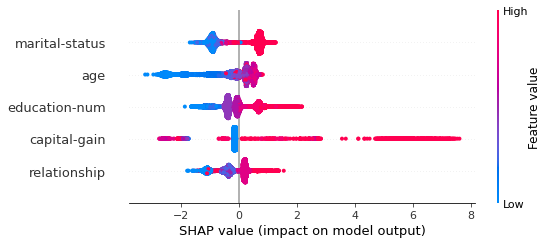

Getting value for estimator
Setting value for importance_df
Getting value for importance_df
                 0         1
0              age   0.68376
1        workclass  0.082545
2           fnlwgt  0.104347
3        education  0.027408
4    education-num  0.484324
5   marital-status  0.793361
6       occupation   0.34871
7     relationship  0.447473
8             race  0.039561
9              sex  0.127074
10    capital-gain  0.454634
11    capital-loss  0.142584
12  hours-per-week  0.366987
13  native-country  0.036742
Getting value for importance_df
Getting value for importance_df
       column_name shap_importance
0              age         0.68376
1        workclass        0.082545
2           fnlwgt        0.104347
3        education        0.027408
4    education-num        0.484324
5   marital-status        0.793361
6       occupation         0.34871
7     relationship        0.447473
8             race        0.039561
9              sex        0.127074
10    capital-gain      

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [10]:
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)


# Check performance of the Pipeline

In [11]:
print('F1 score : ')
print(f1_score(y_test,y_pred))
print('Classification report : ')
print(classification_report(y_test,y_pred))
print('Confusion matrix : ')
print(confusion_matrix(y_test,y_pred))


F1 score : 
0.6133274879438844
Classification report : 
              precision    recall  f1-score   support

           0       0.86      0.93      0.90      8158
           1       0.71      0.54      0.61      2588

    accuracy                           0.84     10746
   macro avg       0.79      0.74      0.75     10746
weighted avg       0.83      0.84      0.83     10746

Confusion matrix : 
[[7583  575]
 [1189 1399]]
